In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.impute import SimpleImputer


In [35]:
data = pd.read_csv("city_day.csv")

In [36]:
# Drop duplicates and invalid data
data = data.drop_duplicates()
data = data.dropna(subset=["AQI"])


In [37]:
# Replace negative pollutant values with NaN, then impute
pollutants = ["PM2.5", "PM10", "NO2", "CO", "SO2", "O3"]
for p in pollutants:
    data.loc[data[p] < 0, p] = np.nan

In [38]:

# Fill missing pollutant values with median
data[pollutants] = data[pollutants].fillna(data[pollutants].median())

In [39]:
# Convert date to datetime
data["Date"] = pd.to_datetime(data["Date"])

In [40]:
print("Data cleaned successfully!")
print(data.info())


Data cleaned successfully!
<class 'pandas.core.frame.DataFrame'>
Index: 24850 entries, 28 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        24850 non-null  object        
 1   Date        24850 non-null  datetime64[ns]
 2   PM2.5       24850 non-null  float64       
 3   PM10        24850 non-null  float64       
 4   NO          24463 non-null  float64       
 5   NO2         24850 non-null  float64       
 6   NOx         22993 non-null  float64       
 7   NH3         18314 non-null  float64       
 8   CO          24850 non-null  float64       
 9   SO2         24850 non-null  float64       
 10  O3          24850 non-null  float64       
 11  Benzene     21315 non-null  float64       
 12  Toluene     19024 non-null  float64       
 13  Xylene      9478 non-null   float64       
 14  AQI         24850 non-null  float64       
 15  AQI_Bucket  24850 non-null  object        
dtyp

CITY SELECTION & EXPLORATORY DATA ANALYSIS (EDA)

In [41]:
city_name = "Delhi"
city_data = data[data["City"] == city_name].copy()

In [42]:
# Summary statistics
print(city_data.describe())
print(city_data.isnull().sum())

                                Date        PM2.5         PM10           NO  \
count                           1999  1999.000000  1999.000000  1998.000000   
mean   2017-10-01 10:10:51.925963008   117.515370   228.183672    39.023544   
min              2015-01-01 00:00:00    10.240000    18.590000     3.570000   
25%              2016-05-14 12:00:00    57.255000   127.580000    15.867500   
50%              2017-10-06 00:00:00    94.890000   210.210000    27.200000   
75%              2019-02-17 12:00:00   153.305000   308.000000    50.980000   
max              2020-07-01 00:00:00   685.360000   796.880000   221.030000   
std                              NaN    82.918968   122.350792    33.446094   

               NO2          NOx          NH3           CO          SO2  \
count  1999.000000  1999.000000  1991.000000  1999.000000  1999.000000   
mean     50.749630    58.809080    42.056595     1.985213    15.570620   
min      10.630000     0.000000     6.780000     0.000000     2.65

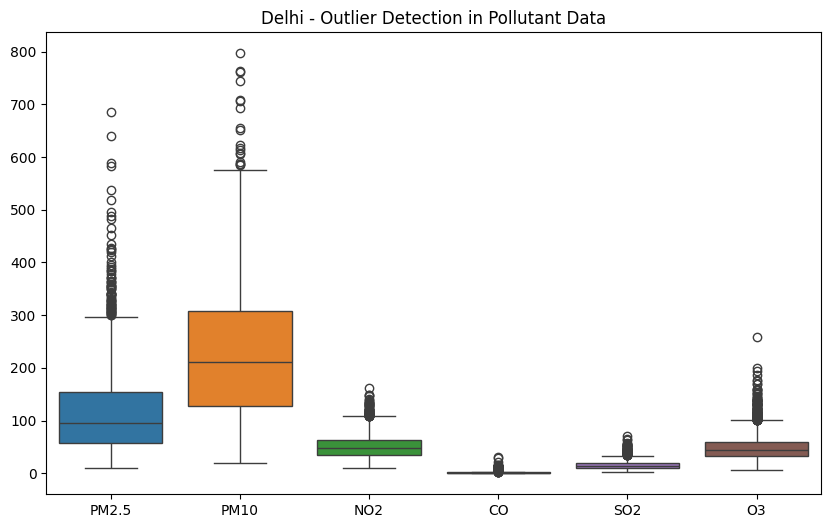

In [43]:

# Outlier Detection
plt.figure(figsize=(10,6))
sns.boxplot(data=city_data[pollutants])
plt.title(f"{city_name} - Outlier Detection in Pollutant Data")
plt.show()

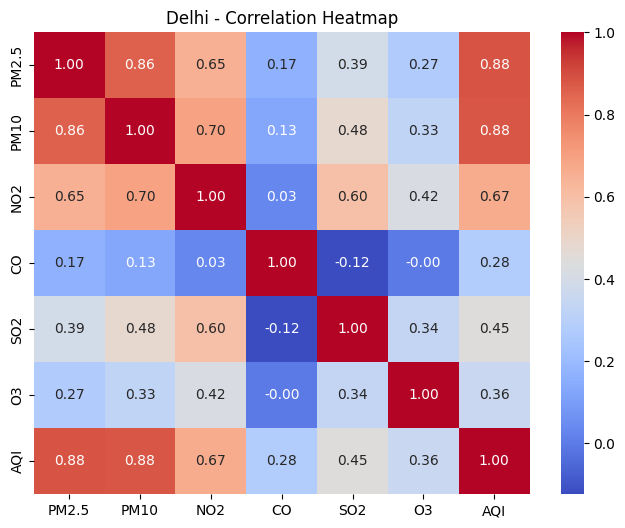

In [44]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(city_data[pollutants + ["AQI"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"{city_name} - Correlation Heatmap")
plt.show()


FEATURE ENGINEERING & TREND VISUALIZATION

In [45]:
city_data["AQI_30d"] = city_data["AQI"].rolling(window=30, min_periods=5).mean()
city_data["Year"] = city_data["Date"].dt.year
city_data["Month"] = city_data["Date"].dt.month
city_data["Day"] = city_data["Date"].dt.day

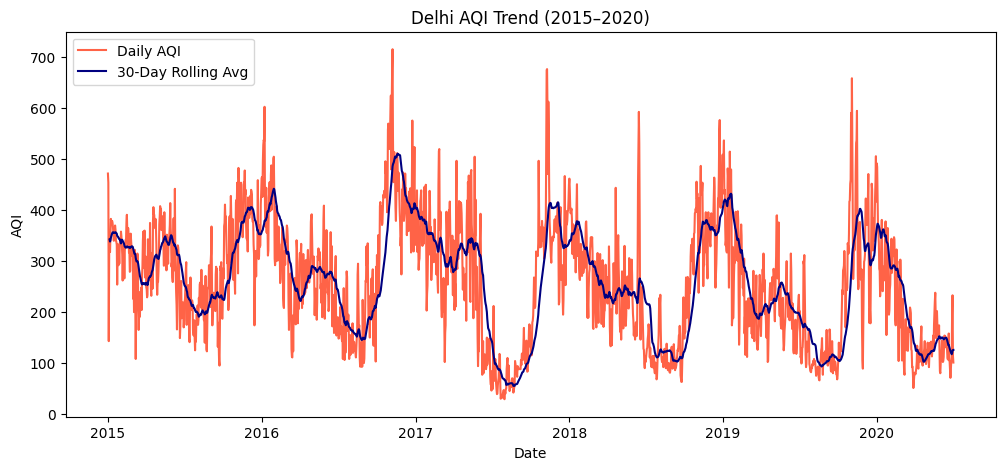

In [46]:
# AQI Trend Over Time
plt.figure(figsize=(12,5))
plt.plot(city_data["Date"], city_data["AQI"], color="tomato", label="Daily AQI")
plt.plot(city_data["Date"], city_data["AQI_30d"], color="navy", label="30-Day Rolling Avg")
plt.title(f"{city_name} AQI Trend (2015–2020)")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()


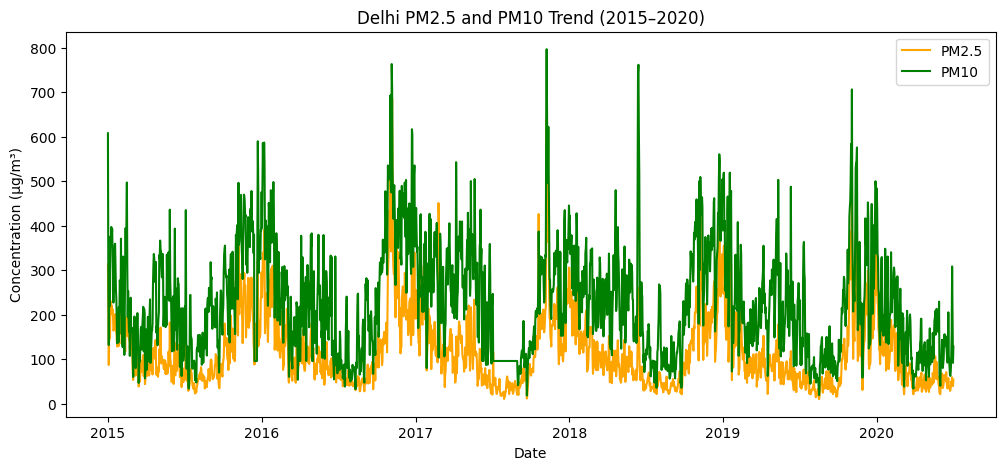

In [47]:
# PM2.5 vs PM10 Trend
plt.figure(figsize=(12,5))
plt.plot(city_data["Date"], city_data["PM2.5"], label="PM2.5", color="orange")
plt.plot(city_data["Date"], city_data["PM10"], label="PM10", color="green")
plt.title(f"{city_name} PM2.5 and PM10 Trend (2015–2020)")
plt.xlabel("Date")
plt.ylabel("Concentration (µg/m³)")
plt.legend()
plt.show()

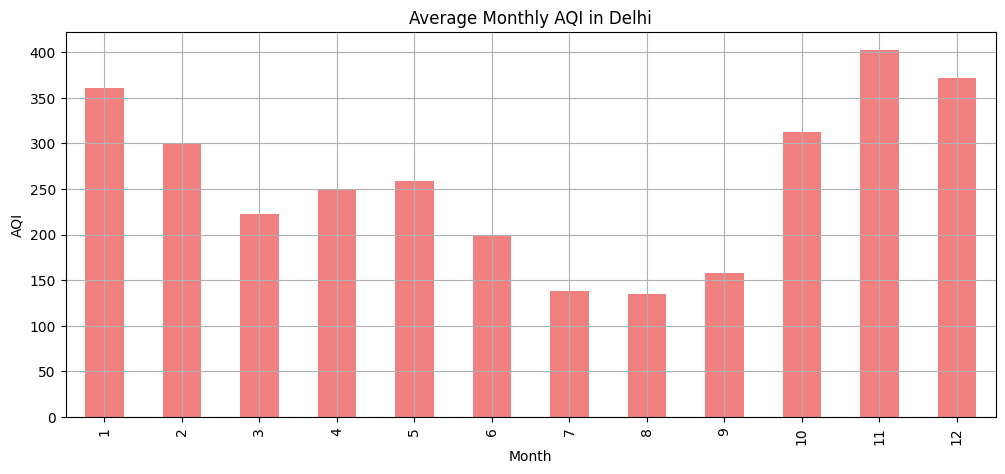

In [48]:
# Monthly Average AQI
plt.figure(figsize=(12,5))
city_data.groupby("Month")["AQI"].mean().plot(kind="bar", color="lightcoral")
plt.title(f"Average Monthly AQI in {city_name}")
plt.ylabel("AQI")
plt.grid(True)
plt.show()

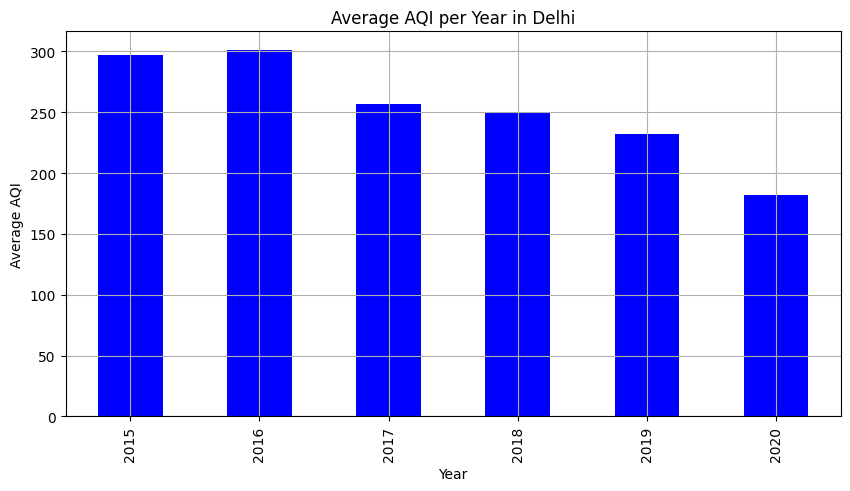

In [49]:
# YEARLY AQI BAR GRAPH
plt.figure(figsize=(10,5))
city_data.groupby('Year')['AQI'].mean().plot(kind='bar', color='blue')
plt.title(f"Average AQI per Year in {city_name}")
plt.ylabel("Average AQI")
plt.grid(True)
plt.show()

REGRESSION MODEL DEVELOPMENT

In [50]:
city_data["AQI_next_day"] = city_data["AQI"].shift(-1)
city_data = city_data.dropna(subset=["AQI_next_day"])


In [51]:
features = ["PM2.5", "PM10", "NO2", "CO", "SO2", "O3"]
X = city_data[features]
y = city_data["AQI_next_day"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [52]:
# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [67]:
# Train Models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)


lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [68]:
# Predict
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_dt = dt.predict(X_test)



# Evaluate
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Decision Tree R²:", r2_score(y_test, y_pred_dt))

print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_dt))


Linear Regression R²: 0.8328931227056577
Random Forest R²: 0.8856825642092736
Decision Tree R²: 0.7758334247787649
Linear Regression MSE: 2159.475843848637
Random Forest MSE: 1477.2925274999998
Decision Tree MSE: 2896.8425


MODEL EVALUATION (REGRESSION)

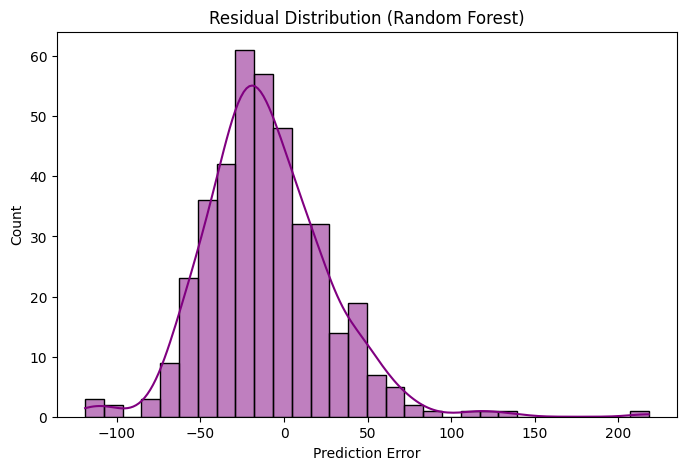

In [55]:
# Residual Plot
plt.figure(figsize=(8,5))
sns.histplot(y_test - y_pred_rf, bins=30, kde=True, color="purple")
plt.title("Residual Distribution (Random Forest)")
plt.xlabel("Prediction Error")
plt.show()

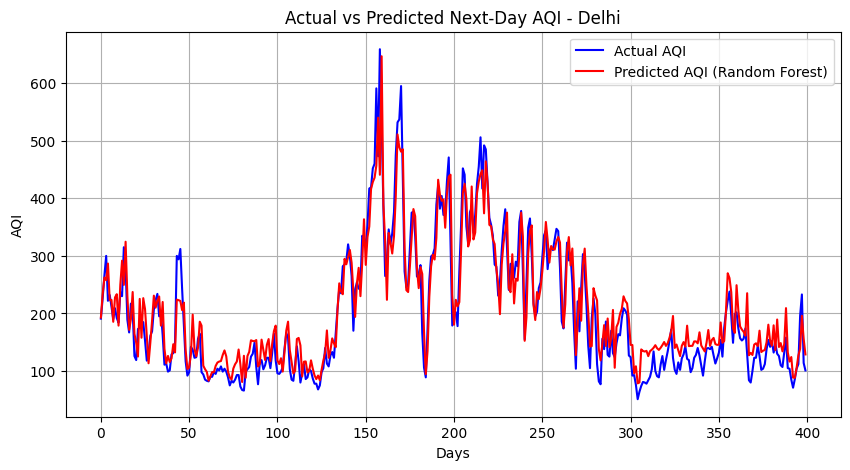

In [56]:
# Compare Actual vs Predicted AQI
plt.figure(figsize=(10,5))

y_test = y_test.reset_index(drop=True)
y_pred_rf = pd.Series(y_pred_rf).reset_index(drop=True)

plt.plot(y_test, label='Actual AQI', color='blue')
plt.plot(y_pred_rf, label='Predicted AQI (Random Forest)', color='red')

plt.title(f"Actual vs Predicted Next-Day AQI - {city_name}")
plt.xlabel("Days")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

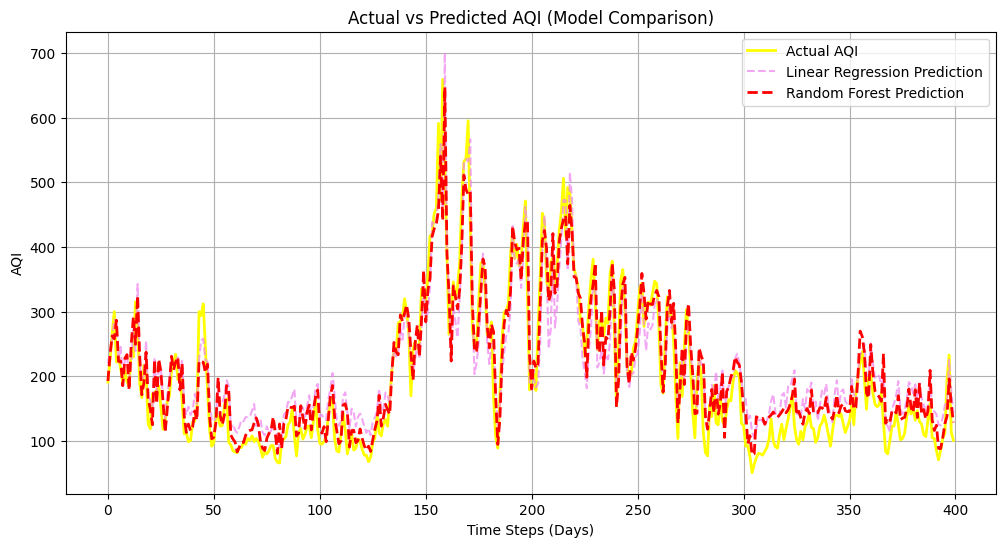

In [57]:
plt.figure(figsize=(12,6))
plt.plot(y_test.reset_index(drop=True).values, label="Actual AQI", color="Yellow", linewidth=2)
plt.plot(y_pred_lr, label="Linear Regression Prediction", color="violet", linestyle='--', alpha=0.7)
plt.plot(y_pred_rf, label="Random Forest Prediction", color="red", linestyle='--', linewidth=2)
plt.title("Actual vs Predicted AQI (Model Comparison)")
plt.xlabel("Time Steps (Days)")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

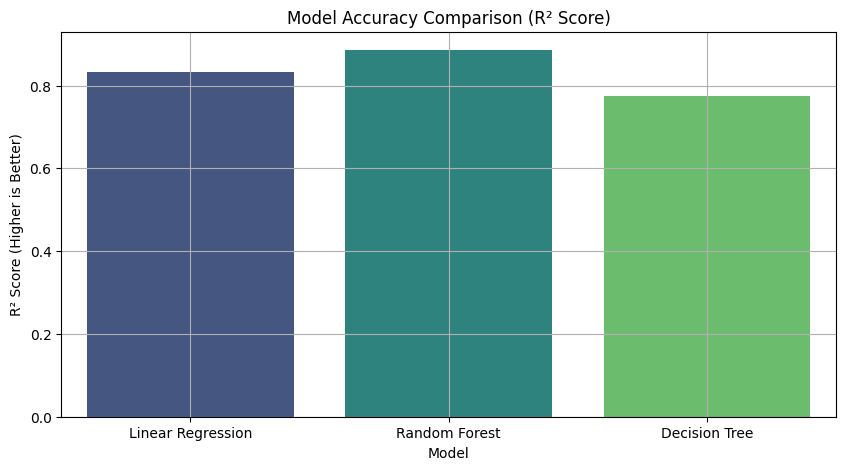

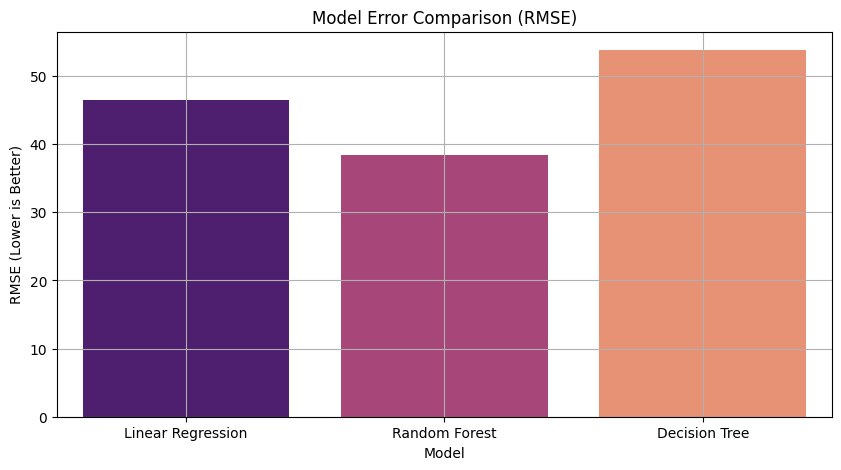

In [69]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Decision Tree'],
    'R2': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_dt)],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        np.sqrt(mean_squared_error(y_test, y_pred_dt))
    ]
})

fig, ax1 = plt.subplots(figsize=(10,5))

# Bar for R²
sns.barplot(x='Model', y='R2', data=results, ax=ax1, palette='viridis', hue='Model', legend=False)
ax1.set_title("Model Accuracy Comparison (R² Score)")
ax1.set_ylabel("R² Score (Higher is Better)")
ax1.grid(True)
plt.show()

# Bar for RMSE
fig, ax2 = plt.subplots(figsize=(10,5))
sns.barplot(x='Model', y='RMSE', data=results, ax=ax2, palette='magma', hue='Model', legend=False)
ax2.set_title("Model Error Comparison (RMSE)")
ax2.set_ylabel("RMSE (Lower is Better)")
ax2.grid(True)
plt.show()

/tmp/ipython-input-2099447056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='coolwarm')


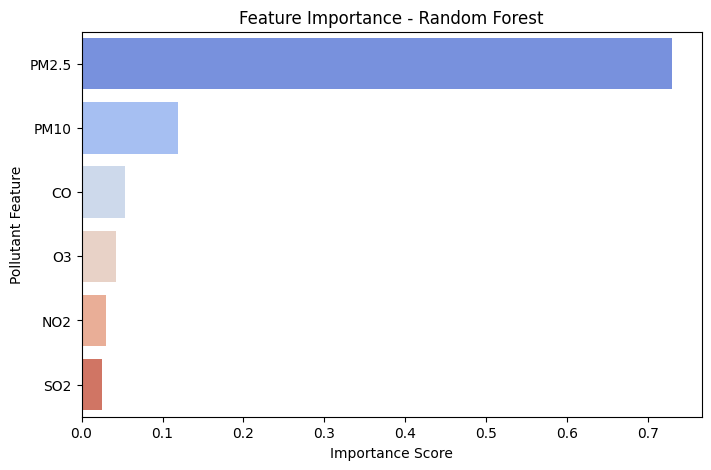

In [59]:
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index, palette='coolwarm')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Pollutant Feature")
plt.show()

MODEL OPTIMIZATION (HYPERPARAMETER TUNING)

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Params: {'max_depth': 10, 'n_estimators': 200}
Best Score: 0.699229557375741


CLASSIFICATION MODEL (AQI CATEGORY)

In [29]:
# CLASSIFICATION (AQI Category)
def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Satisfactory"
    elif aqi <= 200:
        return "Moderate"
    elif aqi <= 300:
        return "Poor"
    elif aqi <= 400:
        return "Very Poor"
    else:
        return "Severe"

city_data["AQI_Category"] = city_data["AQI"].apply(categorize_aqi)

In [30]:
# Prepare data for classification
X_class = city_data[features]
y_class = city_data["AQI_Category"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, shuffle=False)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_c, y_train_c)
y_pred_class = log_model.predict(X_test_c)

print("\nClassification Report:")
print(classification_report(y_test_c, y_pred_class))


Classification Report:
              precision    recall  f1-score   support

    Moderate       0.64      0.79      0.71       175
        Poor       0.61      0.84      0.70        79
Satisfactory       0.00      0.00      0.00        68
      Severe       0.82      0.88      0.85        26
   Very Poor       0.83      0.77      0.80        52

    accuracy                           0.67       400
   macro avg       0.58      0.66      0.61       400
weighted avg       0.56      0.67      0.61       400



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

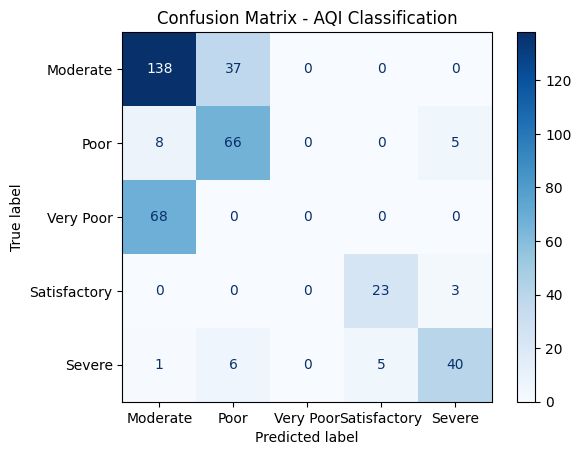

In [31]:
# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_class)
ConfusionMatrixDisplay(cm, display_labels=y_test_c.unique()).plot(cmap="Blues")
plt.title("Confusion Matrix - AQI Classification")
plt.show()

In [72]:
comparison = pd.DataFrame({
    'Date': city_data.iloc[-len(y_test):]['Date'].values,
    'Actual_AQI': y_test.values,
    'Predicted_AQI': y_pred_rf
})
print(f"\nActual and prediction for {city_name}:")
display(comparison.tail(10))


Actual and prediction for Delhi:


,Date,Actual_AQI,Predicted_AQI
390,2020-06-21,104.0,116.34
391,2020-06-22,85.0,124.30
392,2020-06-23,71.0,88.55
393,2020-06-24,86.0,88.21
394,2020-06-25,104.0,105.35
395,2020-06-26,112.0,126.94
396,2020-06-27,196.0,138.36
397,2020-06-28,233.0,195.84
398,2020-06-29,114.0,156.00
399,2020-06-30,101.0,128.81


In [71]:
# FINAL OUTPUT & SUMMARY

# Compare R² scores among the three regression models
r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)
r2_dt = r2_score(y_test, y_pred_dt)

# Determine the best model automatically
best_r2 = max(r2_lr, r2_rf, r2_dt)

if best_r2 == r2_rf:
    best_model = "Random Forest"
    predicted_next_day_aqi = y_pred_rf[-1]
elif best_r2 == r2_dt:
    best_model = "Decision Tree"
    predicted_next_day_aqi = y_pred_dt[-1]
else:
    best_model = "Linear Regression"
    predicted_next_day_aqi = y_pred_lr[-1]

# Categorize the predicted AQI
predicted_category = categorize_aqi(predicted_next_day_aqi)

# Display summary
print(f"Best Model: {best_model}")
print(f"Predicted Next-Day AQI for {city_name}: {predicted_next_day_aqi:.2f} ({predicted_category})")


Best Model: Random Forest
Predicted Next-Day AQI for Delhi: 128.81 (Moderate)
